# Example use case for using connectors module
By Gregory Glickert

First we will start with an example network 

In [12]:
import os

import numpy as np
from bmtk.builder import NetworkBuilder
from bmtk.builder.auxi.node_params import positions_cuboid, positions_list

# cell count
num_of_PN = 400
num_of_FSI = 100
# generate random positions
positions = positions_cuboid(num_of_PN+num_of_FSI,min_dist=10)

# select locations 
inds = np.random.choice(np.arange(0, np.size(positions, 0)), num_of_PN, replace=False)
pos = positions[inds, :]
net = NetworkBuilder('bio_net')
net.add_nodes(N=num_of_PN, 
              pop_name='PN',
              positions=positions_list(pos),
              model_type='biophysical',
              morphology=None)
# Get rid of coordinates already used
positions = np.delete(positions, inds, 0)

inds = np.random.choice(np.arange(0, np.size(positions, 0)), num_of_FSI, replace=False)
pos = positions[inds, :]
net.add_nodes(N=num_of_FSI, 
              pop_name='FSI',
              positions=positions_list(pos),
              model_type='biophysical',
              morphology=None)

background = NetworkBuilder('background')
background.add_nodes(N=num_of_FSI+num_of_PN,
                   pop_name='background_nodes',
                   potential='exc',
                   model_type='virtual')


Now that we have our nodes we can start building some edges with the bmtool.connectors module. There are two main types of network models either homogenous or distance depended. A homogenous network will form connections using a constant probability, while a distance depended model will vary its probability based off how far away the cell pairs are from each other. The connector functions are able to use either type of probability.

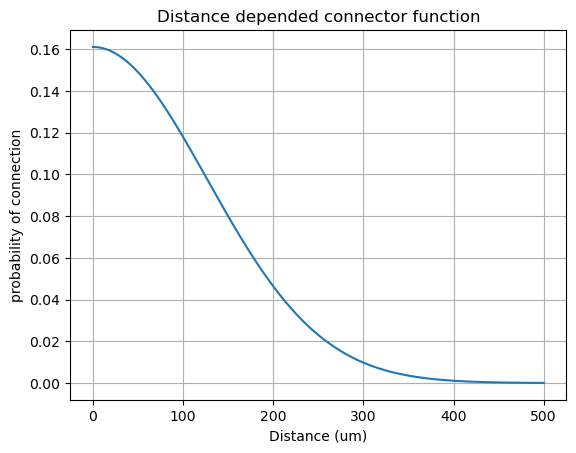

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from bmtool.connectors import GaussianDropoff

%matplotlib inline

drop_off = GaussianDropoff(stdev=126.77, min_dist=0, max_dist=300,
                           ptotal=0.1538, ptotal_dist_range=(0, 50.),
                           dist_type='spherical')

distances = np.linspace(0, 500, 1000)
probabilities_for_dropoff = drop_off.probability(distances)
plt.plot(distances, probabilities_for_dropoff,label=f'Pmax={drop_off.pmax:.2f} Sigma={drop_off.stdev}')
plt.title("Distance depended connector function")
plt.xlabel("Distance (um)")
plt.ylabel("probability of connection")
plt.grid(True)
plt.show()

## UnidirectionalConnector
The UnidirectionalConnector will make one way or forward connection from the source population to the target population. p is the probability of a connection forming. P can be constant or a deterministic function whose value must be within the range 0 to 1. When p is a constant this will form a homogenous network and the deterministic function can be used to make a distance depended network. There is an optional argument p_arg which are input argument(s) for the p function when using a deterministic function. The example below will use the built in GaussianDropoff.



In [14]:
from bmtool.connectors import UnidirectionConnector, spherical_dist

# distance depeneded example 
connector = UnidirectionConnector(p=drop_off, # function from above cell
                                  p_arg=spherical_dist, # spherical distance meaning check x,y,z for distance calculation
                                  verbose=False,
                                  save_report=False)
connector.setup_nodes(source=net.nodes(pop_name = ['PN']), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())

# constant p example
connector = UnidirectionConnector(p=0.10,verbose=True,save_report=False)
connector.setup_nodes(source=net.nodes(pop_name = ['PN']), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())

## ReciprocalConnector
The ReciprocalConnector takes in similar arguments but this time we have p0,p1 and pr. p0 is the probability of a forward connections, p1 is the probability of a backwards connection or a connection from target to source. pr is the probability of reciprocal connection. This connections can get very complex and the Pydocs [here](https://github.com/cyneuro/bmtool/blob/master/bmtool/connectors.py#L408) has more details on how to use the function.

An important thing to note here is how the ReciprocalConnector is called twice. Once for the forward connection and once for the backwards connection. The connector will factor in the reciprocal connections while doing the forward and backwards connections.

The `ReciprocalConnector` uses three key probabilities to model bidirectional connections between neurons:

- **P0**: The probability of a forward connection (from source population to target population).
- **P1**: The probability of a backward connection (from target population to source population).
- **Pr**: The probability of a reciprocal connection (both directions exist).

These probabilities determine the likelihood of different connection types for each pair of neurons:

- **Unidirectional forward connection** (source → target only): `P0 - Pr`
- **Unidirectional backward connection** (target → source only): `P1 - Pr`
- **Bidirectional (reciprocal) connection** (both directions): `Pr`
- **No connection**: `1 - P0 - P1 + Pr`

When `Pr = P0 × P1`, the forward and backward connections are statistically independent. Values of `Pr` higher than `P0 × P1` indicate positive correlation between the directions, while lower values indicate negative correlation.

The correlation coefficient ρ can be calculated as:
```
ρ = (Pr - P0 × P1) / √(P0 × (1 - P0) × P1 × (1 - P1))
```

This framework allows modeling realistic neural connectivity where bidirectional connections are more or less likely than expected by chance.

In [15]:
from bmtool.connectors import ReciprocalConnector

# sets up a homogeneous network with forward prob of 22%, backward prob of 36%, and reciprocal prob of 17% for both connections 
connector = ReciprocalConnector(p0=0.22,p1=0.36,pr=0.17,verbose=True,save_report=False)
connector.setup_nodes(source=net.nodes(pop_name = ['PN']), target=net.nodes(pop_name = ['FSI']))
net.add_edges(**connector.edge_params())
# have to run setup_nodes for both directions since we have forwards and backwards probs.
connector.setup_nodes(source=net.nodes(pop_name = ['FSI']), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())

## GapJunction
The GapJunction connector is similar to the UnidirectionConnector, but will only form electrical synapses between pairs. So in this example we would connect 10% of the FSI cells to each other with gap junction. 

In [16]:
from bmtool.connectors import GapJunction

connector = GapJunction(p=0.10,verbose=False,save_report=False)
connector.setup_nodes(source=net.nodes(pop_name = ['FSI']), target=net.nodes(pop_name = ['FSI']))
net.add_edges(is_gap_junction=True,**connector.edge_params())

## CorrelatedGapJunction
The CorrelatedGapJunction connector creates gap junctions where the probability depends on the presence of chemical synapses between the same pairs. It uses conditional probabilities:

- **p_non**: Probability of gap junction for pairs with no chemical synapses
- **p_uni**: Probability of gap junction for pairs with unidirectional chemical synapses  
- **p_rec**: Probability of gap junction for pairs with reciprocal chemical synapses
- **connector**: The chemical synapse connector object (must be set up first)

This models the experimental observation that electrical and chemical coupling are often correlated.

In [17]:
from bmtool.connectors import CorrelatedGapJunction

# First, create chemical synapses in FSI population
chemical_connector = ReciprocalConnector(p0=0.10, p1=0.10, pr=0.05, verbose=False, save_report=False)
chemical_connector.setup_nodes(source=net.nodes(pop_name=['FSI']), target=net.nodes(pop_name=['FSI']))
net.add_edges(**chemical_connector.edge_params())

# Then create correlated gap junctions based on chemical connections
gap_connector = CorrelatedGapJunction(
    p_non=0.02,    # Low probability for pairs with no chemical synapses
    p_uni=0.08,    # Higher probability for unidirectional chemical pairs
    p_rec=0.15,    # Highest probability for reciprocal chemical pairs
    connector=chemical_connector,  # Reference to chemical connector
    verbose=False, 
    save_report=False
)
gap_connector.setup_nodes(source=net.nodes(pop_name=['FSI']), target=net.nodes(pop_name=['FSI']))
net.add_edges(is_gap_junction=True, **gap_connector.edge_params())

## GapJunctionConditionalReciprocalConnector

The GapJunctionConditionalReciprocalConnector creates chemical synapses where the connection probabilities depend on the presence of gap junctions between cell pairs. This models the experimentally observed correlation between electrical and chemical coupling in neural populations.

It uses different bivariate Bernoulli probability distributions for chemical synapses based on electrical coupling status:
- Electrically coupled pairs: Use p0_elec, p1_elec, pr_elec probabilities
- Non-electrically coupled pairs: Use p0_nonelec, p1_nonelec, pr_nonelec probabilities

In [18]:
from bmtool.connectors import GapJunctionConditionalReciprocalConnector

# Example: Conditional chemical synapses based on gap junctions in FSI population
# Note: This example assumes no prior connections in FSI

# First, create gap junctions
gap_connector_fsi = GapJunction(p=0.08, verbose=True, save_report=False)
gap_connector_fsi.setup_nodes(source=net.nodes(pop_name=['FSI']), target=net.nodes(pop_name=['FSI']))
net.add_edges(is_gap_junction=True, **gap_connector_fsi.edge_params())

# Then create conditional chemical synapses
conditional_chemical_connector = GapJunctionConditionalReciprocalConnector(
    gap_connector=gap_connector_fsi,
    p0_elec=0.50, p1_elec=0.50, pr_elec=0.25,        # For electrically coupled pairs
    p0_nonelec=0.125, p1_nonelec=0.125, pr_nonelec=0.03,  # For non-electrically coupled pairs
    verbose=True, save_report=False
)
conditional_chemical_connector.setup_nodes(source=net.nodes(pop_name=['FSI']), target=net.nodes(pop_name=['FSI']))
net.add_edges(**conditional_chemical_connector.edge_params())

## OneToOneSequentialConnector
The OneToOneSequentialConnector is a way to connect two populations one to one. Meaning that only one node from pop A will form a synapse onto one node from pop B. This is normally how background synapses can be modeled. In the example below, one background node is connected to one PN cell in our network. 

In [19]:
from bmtool.connectors import OneToOneSequentialConnector

connector = OneToOneSequentialConnector(verbose=True)
connector.setup_nodes(source=background.nodes(), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())
connector.setup_nodes(target=net.nodes(pop_name = 'FSI'))
net.add_edges(**connector.edge_params())

All target population partitions are filled.


## Checking connections made
There are several ways in bmtool to check the connections made and to make sure everything was set up correctly. One way to do this is by analyzing the output of `net.build()`. When calling `net.build` any connection that has verbose=True will have a print out showing some connection details. Of course another way to check the connections made is by using the bmplot.connections module part of bmtool.

In [20]:
net.build()


Start building connection 
  from bio_net: pop_name=='['PN']'
  to bio_net: pop_name=='['PN']'
Number of connected pairs: 16018
Number of possible connections: 160000
Fraction of connected pairs in possible ones: 10.01%
Number of total pairs: 160000
Fraction of connected pairs in all pairs: 10.01%

Done! 
Time for building connections: 0.321 sec

Start building connection between: 
  bio_net: pop_name=='['PN']'
  bio_net: pop_name=='['FSI']'
Estimated value of rho=0.457
Time for estimating rho: 0.046 sec
Total time for creating connection matrix: 0.407 sec
Numbers of (forward, backward, reciprocal) connections:
Number of connected pairs: (8871, 14422, 6871)
Number of possible connections: (40000, 40000, 40000)
Fraction of connected pairs in possible ones: (22.18%, 36.05%, 17.18%)
Number of total pairs: 40000
Fraction of connected pairs in all pairs: (22.18%, 36.05%, 17.18%)

Assigning forward connections.
Assigning backward connections.
Done! 
Time for building connections: 0.082 sec


## Additional Edge Properties
Beyond connection probabilities, you can add properties to edges such as synaptic delays, weights, and synapse locations. The bmtool.connectors module provides utility functions for common properties.

For example, you can add distance-dependent delays or constant delays. These functions can access the connector's connection properties (like distance) if the connector is passed as an argument. Another important parameter is the synaptic location, which can be varied probabilistically along different sections of the dendrite.

Synaptic delays are often modeled as distance-dependent to account for conduction time along axons. The delay typically increases linearly with distance, with some minimum delay and possible random fluctuations. Below is an example of how to use these property rules, followed by a plot illustrating how distance-dependent delay works.

The example below creates connections between ~10% of PN pairs. For each synapse, 80% are placed at section ID 2, position 0.8 (e.g., basal dendrites), and 20% at section ID 3, position 0.8 (e.g., apical dendrites). It also adds distance-dependent delays with specified minimum delay and bounds. 

In [21]:
from bmtool.connectors import syn_dist_delay_feng_section_PN
from functools import partial

edge_add_properties = {
    'syn_dist_delay_E2E': {
        'names': ['delay', 'afferent_section_id', 'afferent_section_pos'],
        'rule': syn_dist_delay_feng_section_PN,
        'rule_params': {
            'p': 0.8, 'sec_id': (2, 3), 'sec_x': (0.8, 0.8),
            'min_delay': 1.6, 'delay_bound': (0.2, 2.4)
        },
        'dtypes': [float, np.uint16, float]
    }}

connector = UnidirectionConnector(p=0.10,verbose=False,save_report=False)
connector.setup_nodes(source=net.nodes(pop_name = ['PN']), target=net.nodes(pop_name = ['PN']))
conn = net.add_edges(**connector.edge_params())

edge_properties_val = edge_add_properties['syn_dist_delay_E2E'].copy()
edge_properties_val['rule'] = partial(edge_properties_val['rule'], connector=connector)
conn.add_properties(**edge_properties_val)

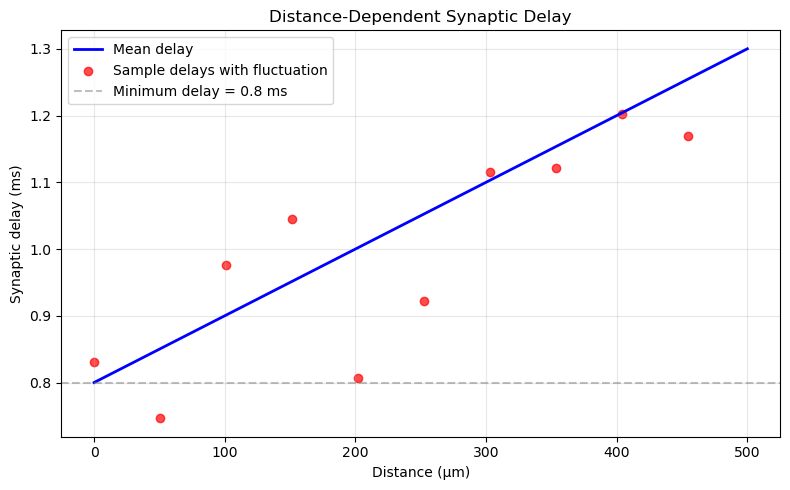

Delay formula: delay = distance / 1000.0 + 0.8 + random_fluctuation
At 0 μm: 0.8 ms
At 500 μm: 1.3 ms


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Plot illustrating distance-dependent synaptic delay
distances = np.linspace(0, 500, 100)  # distances in microns
velocity = 1000.0  # um/ms
min_delay = 0.8  # ms
fluc_stdev = 0.1  # ms, for illustration

# Mean delay
mean_delays = distances / velocity + min_delay

# Sample delays with fluctuation
rng = np.random.default_rng(42)
sample_delays = []
for d in distances[::10]:  # every 10th point
    delay = d / velocity + min_delay + fluc_stdev * rng.normal()
    delay = np.clip(delay, 0.2, 2.4)  # bounds
    sample_delays.append(delay)

plt.figure(figsize=(8, 5))
plt.plot(distances, mean_delays, 'b-', label='Mean delay', linewidth=2)
plt.scatter(distances[::10], sample_delays, color='red', alpha=0.7, label='Sample delays with fluctuation')
plt.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label=f'Minimum delay = {min_delay} ms')
plt.xlabel('Distance (μm)')
plt.ylabel('Synaptic delay (ms)')
plt.title('Distance-Dependent Synaptic Delay')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Delay formula: delay = distance / {velocity} + {min_delay} + random_fluctuation")
print(f"At 0 μm: {min_delay} ms")
print(f"At 500 μm: {500/velocity + min_delay:.1f} ms")

## Summary
This notebook demonstrated how to use various connectors from the bmtool.connectors module to build neural networks with different connectivity patterns:

- **UnidirectionalConnector**: For one-way connections with constant or distance-dependent probabilities.
- **ReciprocalConnector**: For bidirectional connections with controlled reciprocal probabilities.
- **GapJunction**: For electrical synapses.
- **CorrelatedGapJunction**: For correlated electrical and chemical synapses.
- **GapJunctionConditionalReciprocalConnector**: For chemical synapses with probabilities conditional on gap junction presence.
- **OneToOneSequentialConnector**: For one-to-one mappings, useful for background inputs.

Each connector can be configured with probability functions, and additional edge properties like delays and synaptic locations can be added. The notebook also includes examples of how to add these properties, visualizations showing how distance-dependent delays work, and methods for checking and analyzing the connections made. The network can then be saved and used for simulations in BMTK.

For more advanced usage, refer to the full documentation and the connector classes' docstrings.